# Group delay calculation from FDTD and mode solver

**Group delay** is a measure of the time it takes for the envelope of a modulated signal (or a pulse) to propagate through a device. Mathematically, group delay is defined as the derivative of the phase response with respect to angular frequency:

$$
\tau_g(\omega) = \frac{d\phi(\omega)}{d\omega}
$$

where $\phi(\omega)$ is the phase of the S-parameter at angular frequency $\omega$. Group delay provides insight into the dispersion and temporal distortion experienced by signals, and is particularly important in high-speed communication systems and photonics, where preserving the shape and timing of signals is crucial.

This notebook demonstrates the group delay calculation using both FDTD and mode solver on the example of a waveguide bend. Both methods yield a consistent result. FDTD has the advantage of being more general as this approach works for the group delay calculation of any device. The mode solver-based approach only works for certain devices where the propagating mode is well defined. 

In [1]:
import gdstk
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.web as web

## FDTD Approach

### Simulation Setup

First we will use FDTD to extract the group delay on the waveguide bend. To start, we define the relevant wavelength and frequency ranges. Although it's technically not necessary, it's more convenient to define the frequency array in an equal spacing and increasing order. 

In [2]:
# define wavelength and frequency ranges
lda0 = 1.55
lda_min = 1.5
lda_max = 1.6

freqs = np.linspace(td.C_0 / lda_max, td.C_0 / lda_min, 101)
ldas = td.C_0 / freqs
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))

We will focus on the case of a single-mode silicon waveguide with oxide cladding. For simplicity we will use the materials from the built-in [material library](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/material_library.html).

In [3]:
si = td.material_library["cSi"]["Palik_Lossless"]
sio2 = td.material_library["SiO2"]["Palik_Lossless"]

Define the geometry parameters. We will define our ports on the straight waveguide, leaving some spacing between the ports and the bend. The bend is a circular bend with a radius of 5 µm. 

In [4]:
l_straight = 2  # length of the straight waveguide
r = 5  # bend radius
w = 0.5  # waveguide width
t = 0.22  # waveguide thickness
inf_eff = 1e3  # effective infinity

Use [gdstk](https://heitzmann.github.io/gdstk/) to create a simple waveguide circular bend.

In [5]:
# create a waveguide bend structure using gdstk
cell = gdstk.Cell("BEND")
path = gdstk.RobustPath(initial_point=(-inf_eff, 0), width=0.5, layer=1, datatype=0)
path.segment(xy=(0, 0))
path.arc(radius=r, initial_angle=-np.pi / 2, final_angle=0)
path.segment(xy=(r, inf_eff))
cell.add(path)

bend = td.Structure(
    geometry=td.PolySlab.from_gds(
        cell,
        gds_layer=1,
        axis=2,
        slab_bounds=(-t / 2, t / 2),
    )[0],
    medium=si,
)

Add the [ModeSource](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ModeSource.html) and [ModeMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ModeMonitor.html) at the port positions. 

In [6]:
# define a mode source
mode_source = td.ModeSource(
    center=(-l_straight, 0, 0),
    size=(0, 4 * w, 6 * t),
    source_time=td.GaussianPulse(freq0=td.C_0 / lda0, fwidth=fwidth),
    mode_spec=td.ModeSpec(),
    mode_index=0,
    direction="+",
    num_freqs=7,
)

# define a mode monitor
mode_monitor = td.ModeMonitor(
    center=(r, r + l_straight, 0),
    size=(4 * w, 0, 6 * t),
    freqs=freqs,
    mode_spec=td.ModeSpec(),
    name="s21",
)

Put together a [Simulation](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Simulation.html) and visualize it.

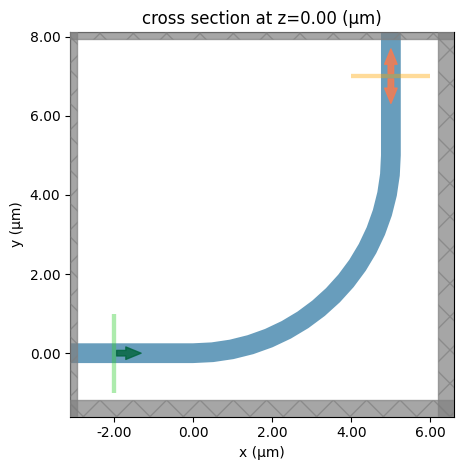

In [7]:
buffer = 0.6 * lda0  # buffer spacing

# define a simulation domain box
sim_box = td.Box.from_bounds(
    rmin=(-l_straight - buffer, -w / 2 - buffer, -w / 2 - buffer),
    rmax=(r + w / 2 + buffer, r + l_straight + buffer, w / 2 + buffer),
)

# define a simulation
sim = td.Simulation(
    center=sim_box.center,
    size=sim_box.size,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=30),
    run_time=5e-13,
    structures=[bend],
    sources=[mode_source],
    monitors=[mode_monitor],
    symmetry=(0, 0, 1),
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    medium=sio2,
)

sim.plot(z=0)
plt.show()

Run the simulation in the cloud. 

In [8]:
sim_data = web.run(simulation=sim, task_name="waveguide_bend")

12:47:59 UTC Created task 'waveguide_bend' with task_id                         
             'fdve-4238aa63-9ae3-4b4e-963f-1c38374cbb97' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=556407;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4238aa63-9ae3-4b4e-963f-1c38374cbb97\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=997937;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4238aa63-9ae3-4b4e-963f-1c38374cbb97\taskId]8;;\]8;id=556407;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4238aa63-9ae3-4b4e-963f-1c38374cbb97\=]8;;\]8;id=216237;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4238aa63-9ae3-4b4e-963f-1c38374cbb97\fdve]8;;\]8;id=556407;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4238aa63-9ae3-4b4e-963f-1c38374cbb97\-4238aa63-9ae]8;;\
             ]8;id=556407;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4238aa63-9ae3-4b4e-963f-1c38374cbb97\3-4b4e-963f-1c38374cbb97']8;;\.

             Task folder: ]8;id=694652;https://tidy3d.simulation.cloud/folders/9b36e144-ddb6-41f8-8dd8-30b62b26a870\'default']8;;\.

Output()

12:48:02 UTC Maximum FlexCredit cost: 0.273. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

12:48:03 UTC status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

12:48:15 UTC status = preprocess

12:48:19 UTC starting up solver

12:48:20 UTC running solver

Output()

12:48:51 UTC early shutoff detected at 84%, exiting.

12:48:52 UTC status = success

             View simulation result at                                          
             ]8;id=705801;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4238aa63-9ae3-4b4e-963f-1c38374cbb97\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=680312;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4238aa63-9ae3-4b4e-963f-1c38374cbb97\taskId]8;;\]8;id=705801;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4238aa63-9ae3-4b4e-963f-1c38374cbb97\=]8;;\]8;id=412205;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4238aa63-9ae3-4b4e-963f-1c38374cbb97\fdve]8;;\]8;id=705801;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4238aa63-9ae3-4b4e-963f-1c38374cbb97\-4238aa63-9ae]8;;\
             ]8;id=705801;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4238aa63-9ae3-4b4e-963f-1c38374cbb97\3-4b4e-963f-1c38374cbb97']8;;\.

Output()

12:48:53 UTC loading simulation from simulation_data.hdf5

### Postprocessing

After the simulation is completed, we first extract the complex S21 and calculate the derivative of the unwrapped phase with respect to frequency. The final group delay is then given by the derivative divided by 2$\pi$.

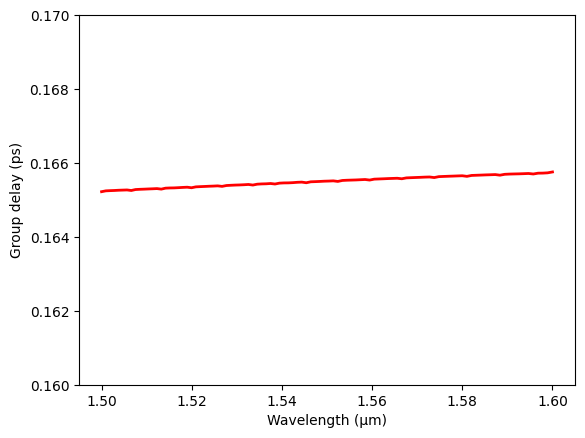

In [9]:
s21 = sim_data["s21"].amps.sel(direction="+").squeeze(drop=True).values  # extract the s-parameter
dphi_df = np.gradient(np.unwrap(np.angle(s21)), freqs)  # calculate gradient
group_delay_fdtd = dphi_df / (2 * np.pi)  # calculate group delay

# plot group delay as a function of wavelength
plt.plot(ldas, group_delay_fdtd * 1e12, c="red", linewidth=2)
plt.xlabel("Wavelength (µm)")
plt.ylabel("Group delay (ps)")
plt.ylim(0.16, 0.17)
plt.show()

## Mode Solver Approach

### Group Index Calculation

Next we demonstrate how to calculate the same group delay only using mode solving. To do so, we need to run mode solving on the same waveguide structure and calculate the group index of the mode. A convenient way to do so is by using the [waveguide plugin](https://www.flexcompute.com/tidy3d/examples/notebooks/WaveguidePluginDemonstration/).

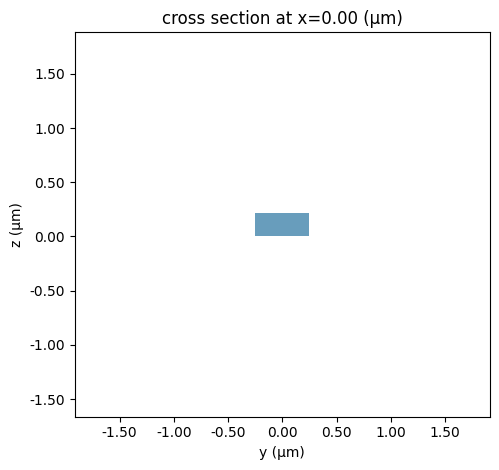

In [10]:
from tidy3d.plugins import waveguide

# define the straight waveguide
wg_straight = waveguide.RectangularDielectric(
    wavelength=ldas,
    core_width=w,
    core_thickness=t,
    core_medium=si,
    clad_medium=sio2,
    grid_resolution=30,
    mode_spec=td.ModeSpec(num_modes=1, precision="double", group_index_step=0.005),
)

wg_straight.plot_structures(x=0)
plt.show()

Run mode solving on the straight waveguide and calculate the group velocity. 

In [11]:
straight_data = web.run(simulation=wg_straight.mode_solver, task_name="straight waveguide")
vg_straight = (
    td.C_0 / straight_data.n_group
)  # calculate the group velocity of the straight waveguide mode

12:48:54 UTC Created task 'straight waveguide' with task_id                     
             'mo-2518acfb-4909-49ed-8ae8-80b9d5e92fc5' and task_type            
             'MODE_SOLVER'.

             View task using web UI at                                          
             ]8;id=158226;https://tidy3d.simulation.cloud/workbench?taskId=mo-2518acfb-4909-49ed-8ae8-80b9d5e92fc5\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=966370;https://tidy3d.simulation.cloud/workbench?taskId=mo-2518acfb-4909-49ed-8ae8-80b9d5e92fc5\taskId]8;;\]8;id=158226;https://tidy3d.simulation.cloud/workbench?taskId=mo-2518acfb-4909-49ed-8ae8-80b9d5e92fc5\=]8;;\]8;id=333762;https://tidy3d.simulation.cloud/workbench?taskId=mo-2518acfb-4909-49ed-8ae8-80b9d5e92fc5\mo]8;;\]8;id=158226;https://tidy3d.simulation.cloud/workbench?taskId=mo-2518acfb-4909-49ed-8ae8-80b9d5e92fc5\-2518acfb-4909-]8;;\
             ]8;id=158226;https://tidy3d.simulation.cloud/workbench?taskId=mo-2518acfb-4909-49ed-8ae8-80b9d5e92fc5\49ed-8ae8-80b9d5e92fc5']8;;\.

             Task folder: ]8;id=830749;https://tidy3d.simulation.cloud/folders/9b36e144-ddb6-41f8-8dd8-30b62b26a870\'default']8;;\.

Output()

12:48:56 UTC Maximum FlexCredit cost: 0.018. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

12:48:57 UTC status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

12:49:02 UTC starting up solver

             running solver

12:49:16 UTC status = success

             View simulation result at                                          
             ]8;id=966101;https://tidy3d.simulation.cloud/workbench?taskId=mo-2518acfb-4909-49ed-8ae8-80b9d5e92fc5\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=137756;https://tidy3d.simulation.cloud/workbench?taskId=mo-2518acfb-4909-49ed-8ae8-80b9d5e92fc5\taskId]8;;\]8;id=966101;https://tidy3d.simulation.cloud/workbench?taskId=mo-2518acfb-4909-49ed-8ae8-80b9d5e92fc5\=]8;;\]8;id=565608;https://tidy3d.simulation.cloud/workbench?taskId=mo-2518acfb-4909-49ed-8ae8-80b9d5e92fc5\mo]8;;\]8;id=966101;https://tidy3d.simulation.cloud/workbench?taskId=mo-2518acfb-4909-49ed-8ae8-80b9d5e92fc5\-2518acfb-4909-]8;;\
             ]8;id=966101;https://tidy3d.simulation.cloud/workbench?taskId=mo-2518acfb-4909-49ed-8ae8-80b9d5e92fc5\49ed-8ae8-80b9d5e92fc5']8;;\.

Output()

12:49:23 UTC loading simulation from simulation_data.hdf5

Similarly, we need to do so for the bend waveguide since the group velocity is potentially slightly different. This can be done by copying the straight waveguide case and updating the mode specification to include a bend radius. 

In [12]:
wg_bend = wg_straight.updated_copy(
    mode_spec=td.ModeSpec(
        num_modes=1,
        bend_radius=r,
        bend_axis=1,
        num_pml=(12, 12),
        precision="double",
        group_index_step=0.005,
    ),
)

bend_data = web.run(simulation=wg_bend.mode_solver, task_name="bend waveguide")
vg_bend = td.C_0 / bend_data.n_group  # calculate the group velocity of the bend waveguide mode

12:49:24 UTC Created task 'bend waveguide' with task_id                         
             'mo-9ff90bd0-c39c-464e-8c2f-e02fa34d4faa' and task_type            
             'MODE_SOLVER'.

             View task using web UI at                                          
             ]8;id=149348;https://tidy3d.simulation.cloud/workbench?taskId=mo-9ff90bd0-c39c-464e-8c2f-e02fa34d4faa\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=719796;https://tidy3d.simulation.cloud/workbench?taskId=mo-9ff90bd0-c39c-464e-8c2f-e02fa34d4faa\taskId]8;;\]8;id=149348;https://tidy3d.simulation.cloud/workbench?taskId=mo-9ff90bd0-c39c-464e-8c2f-e02fa34d4faa\=]8;;\]8;id=444220;https://tidy3d.simulation.cloud/workbench?taskId=mo-9ff90bd0-c39c-464e-8c2f-e02fa34d4faa\mo]8;;\]8;id=149348;https://tidy3d.simulation.cloud/workbench?taskId=mo-9ff90bd0-c39c-464e-8c2f-e02fa34d4faa\-9ff90bd0-c39c-]8;;\
             ]8;id=149348;https://tidy3d.simulation.cloud/workbench?taskId=mo-9ff90bd0-c39c-464e-8c2f-e02fa34d4faa\464e-8c2f-e02fa34d4faa']8;;\.

             Task folder: ]8;id=51433;https://tidy3d.simulation.cloud/folders/9b36e144-ddb6-41f8-8dd8-30b62b26a870\'default']8;;\.

Output()

12:49:27 UTC Maximum FlexCredit cost: 0.018. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

12:49:28 UTC status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

12:49:33 UTC starting up solver

             running solver

12:49:54 UTC status = success

             View simulation result at                                          
             ]8;id=337597;https://tidy3d.simulation.cloud/workbench?taskId=mo-9ff90bd0-c39c-464e-8c2f-e02fa34d4faa\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=68533;https://tidy3d.simulation.cloud/workbench?taskId=mo-9ff90bd0-c39c-464e-8c2f-e02fa34d4faa\taskId]8;;\]8;id=337597;https://tidy3d.simulation.cloud/workbench?taskId=mo-9ff90bd0-c39c-464e-8c2f-e02fa34d4faa\=]8;;\]8;id=400871;https://tidy3d.simulation.cloud/workbench?taskId=mo-9ff90bd0-c39c-464e-8c2f-e02fa34d4faa\mo]8;;\]8;id=337597;https://tidy3d.simulation.cloud/workbench?taskId=mo-9ff90bd0-c39c-464e-8c2f-e02fa34d4faa\-9ff90bd0-c39c-]8;;\
             ]8;id=337597;https://tidy3d.simulation.cloud/workbench?taskId=mo-9ff90bd0-c39c-464e-8c2f-e02fa34d4faa\464e-8c2f-e02fa34d4faa']8;;\.

Output()

12:50:10 UTC loading simulation from simulation_data.hdf5

Finally, the group delay can be calculated by dividing the mode propagation length by the group velocity. We compare the obtained group velocity from FDTD and mode solving. The results are very consistent as expected. 

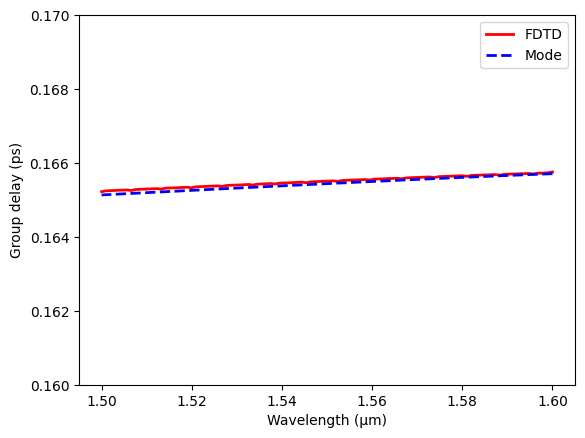

In [13]:
group_delay_mode = 2 * l_straight / vg_straight + 2 * np.pi * r / (
    4 * vg_bend
)  # calculate the total group delay

plt.plot(ldas, group_delay_fdtd * 1e12, c="red", linewidth=2, label="FDTD")
plt.plot(ldas, group_delay_mode * 1e12, "--", c="blue", linewidth=2, label="Mode")
plt.xlabel("Wavelength (µm)")
plt.ylabel("Group delay (ps)")
plt.ylim(0.16, 0.17)
plt.legend()
plt.show()